In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
#from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras.layers import Activation, Dense ,Flatten ,Dropout
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
EPOCHS = 100
INIT_LR = 1e-5
BS = 16
default_image_size = tuple((224,224))
image_size = 0
directory_root = '/content/drive/MyDrive/PLDD Dataset/PLDD Dataset'
width=256
height=256
depth=3

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing leaf spot ...
[INFO] Processing BLB ...
[INFO] Processing leaf folder ...
[INFO] Processing healthy ...
[INFO] Processing hispa ...
[INFO] Processing Blast ...
[INFO] Processing .ipynb_checkpoints ...
[INFO] Image loading completed


In [8]:
image_size = len(image_list)
image_size

636

In [9]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['BLB' 'Blast' 'healthy' 'hispa' 'leaf folder' 'leaf spot']


In [10]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_classes = 6
input_shape = (224, 224, 3)

model = Sequential()
model.add(ResNet50(input_shape=input_shape, include_top=False, pooling='avg', weights=None))

# Adjust the number of units in the Dense layers to match the output shape of ResNet-50
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,213,766 (100.00 MB)

 Trainable params: 26,160,646 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=INIT_LR), metrics=['accuracy'])

# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3670 - loss: 1.6645 - val_accuracy: 0.3516 - val_loss: 1.7681
Epoch 2/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.3125 - loss: 1.5759

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3125 - loss: 1.5759 - val_accuracy: 0.3516 - val_loss: 1.7660
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.3315 - loss: 1.6170 - val_accuracy: 0.3516 - val_loss: 1.7510
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3125 - loss: 1.6350 - val_accuracy: 0.3516 - val_loss: 1.7520
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.3767 - loss: 1.5746 - val_accuracy: 0.3516 - val_loss: 1.7541
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3750 - loss: 1.5422 - val_accuracy: 0.3516 - val_loss: 1.7546
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.3919 - loss: 1.5112 - val_accuracy: 0.3516 - val_loss: 1.7613
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6875 - loss: 1.2603 - val_accuracy: 0.3516 - val_loss: 1.7609
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.3798 - loss: 1.5210 - val_accuracy: 0.3516 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


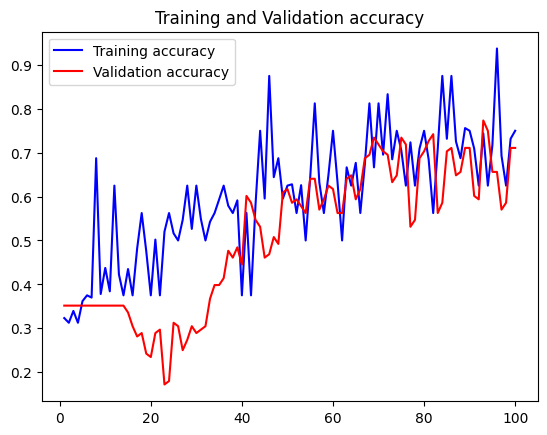

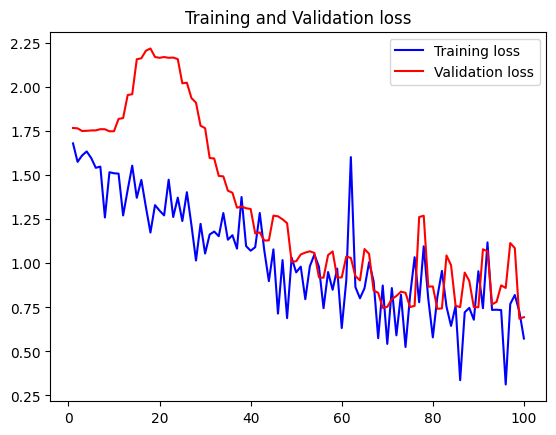

In [14]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import precision_score, f1_score, recall_score

# Assuming you have the model predictions in a variable called y_prob
y_prob = model.predict(x_test)
y_pred = y_prob.argmax(axis=-1)

# Model Evaluation (get accuracy)
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

# Calculate Precision
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')

# Calculate F1 Score
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')

# Calculate Recall
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7146 - loss: 0.6386
Test Accuracy: 71.09%
Precision: 0.74
F1 Score: 0.71
Recall: 0.71


[INFO] Saving model...
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[9.7372681e-01 4.4697445e-04 3.5533812e-03 3.0022215e-03 3.7022066e-05
  1.9233549e-02]]
Predicted Class: BLB
Probability: 0.9737


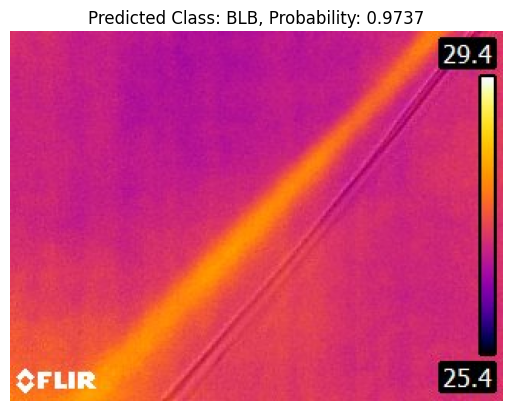

In [17]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/BLB/thermalimage103c.jpg"
# /kaggle/input/thermalimage/thermal images UL/hispa/thermalimage7b.jpg

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[2.5701770e-03 4.3693769e-01 5.3748572e-01 7.9121552e-03 2.1268018e-04
  1.4881588e-02]]
Predicted Class: healthy
Probability: 0.5375


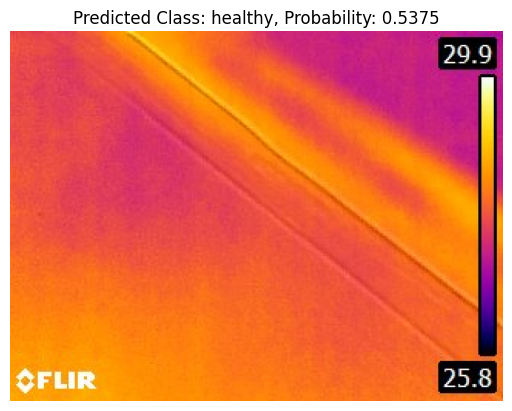

In [19]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/Blast/Thermalimage10a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[6.1366106e-03 1.4377732e-03 8.2895583e-01 1.4753500e-04 3.2509013e-06
  1.6331899e-01]]
Predicted Class: healthy
Probability: 0.8290


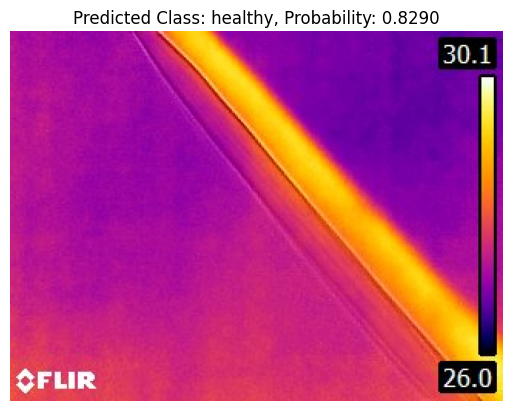

In [22]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/healthy/thermalimage6e.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[5.7509313e-03 6.0179722e-03 2.0191919e-04 9.8465967e-01 1.6857078e-03
  1.6837806e-03]]
Predicted Class: hispa
Probability: 0.9847


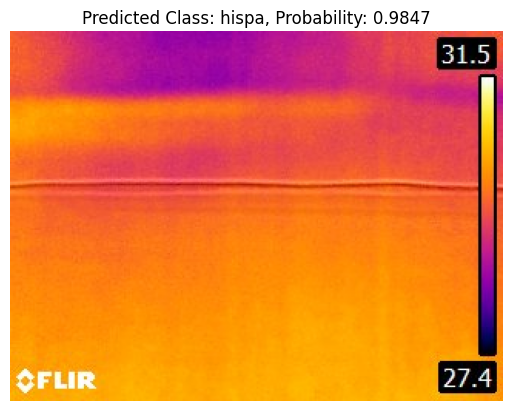

In [21]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/hispa/thermalimage16d.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.05723982 0.0445652  0.10699577 0.00585296 0.22280735 0.5625389 ]]
Predicted Class: leaf spot
Probability: 0.5625


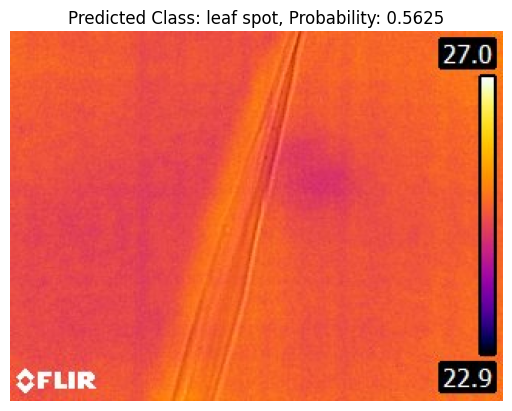

In [23]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/leaf spot/thermalimage2f.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.02491984 0.00781139 0.004458   0.0251322  0.86516947 0.07250912]]
Predicted Class: leaf folder
Probability: 0.8652


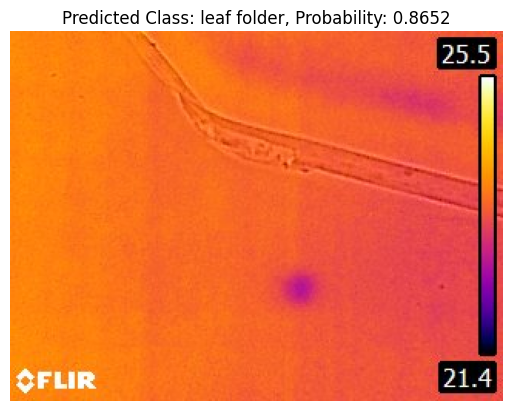

In [24]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/leaf folder/thermalimage19b.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()